### Policy Iteration

In [1]:
import gym,time
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mediapy as media
from moviepy.video.io.bindings import mplfig_to_npimage
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
np.set_printoptions(precision=2,suppress=True)
plt.rc('xtick',labelsize=8); plt.rc('ytick',labelsize=8)
print ("gym:[%s]"%(gym.__version__))
print ("numpy:[%s]"%(np.__version__))
print ("matplotlib:[%s]"%(matplotlib.__version__))

gym:[0.26.2]
numpy:[1.22.4]
matplotlib:[3.7.1]


Helper Function

In [2]:
def plot_env(env,figsize=(4,4),title_str=None,title_fs=10,
             PLOT_IMG=True,RETURN_IMG=False):
    img = env.render()
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    if title_str is not None:
        plt.title(title_str,fontsize=title_fs)
    if PLOT_IMG:
        plt.show()
    # (Optional) Get image
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
    
def visualize_matrix(M,strs='',figsize=(4,4),fontsize=10,
                     cmap='turbo',title='Title',title_fs=10,subplots_top=1.05,
                     REMOVE_TICK_LABELS=True,PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize a matrix colors and strings 
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = M.shape[0],M.shape[1]
    
    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(M,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0),
              interpolation='nearest',aspect='equal')
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    ax.set_frame_on(False)
    x,y = np.meshgrid(np.arange(0,n_col,1.0),np.arange(0,n_row,1.0))
    if len(strs) == n_row*n_col:
        idx = 0
        for x_val,y_val in zip(x.flatten(), y.flatten()):
            c = strs[idx]
            idx = idx + 1
            ax.text(x_val+0.5,y_val+0.5,c,va='center', ha='center',size=fontsize)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=subplots_top)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
print ("Ready.")

Ready.


### Initialize Environment

In [3]:
env = gym.make('FrozenLake8x8-v1',render_mode='rgb_array')
env.reset()
print ("[%s] initialized."%(env.unwrapped.spec.id))

[FrozenLake8x8-v1] initialized.


In [4]:
obs_space = env.observation_space
n_state = obs_space.n
action_space = env.action_space
n_action = action_space.n
print("State space:[%d]"%(n_state))
print("Action space:[%d]"%(n_action))

State space:[64]
Action space:[4]


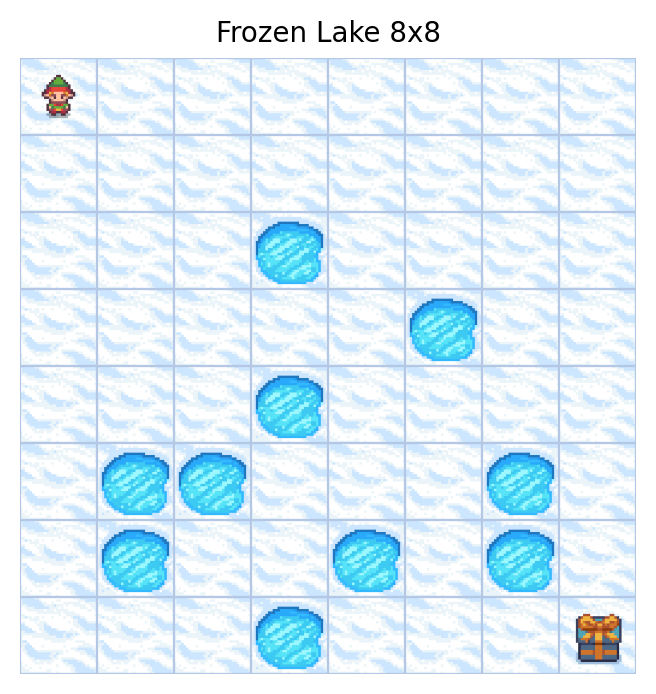

In [5]:
plot_env(env,figsize=(4,4),title_str='Frozen Lake 8x8',title_fs=10)

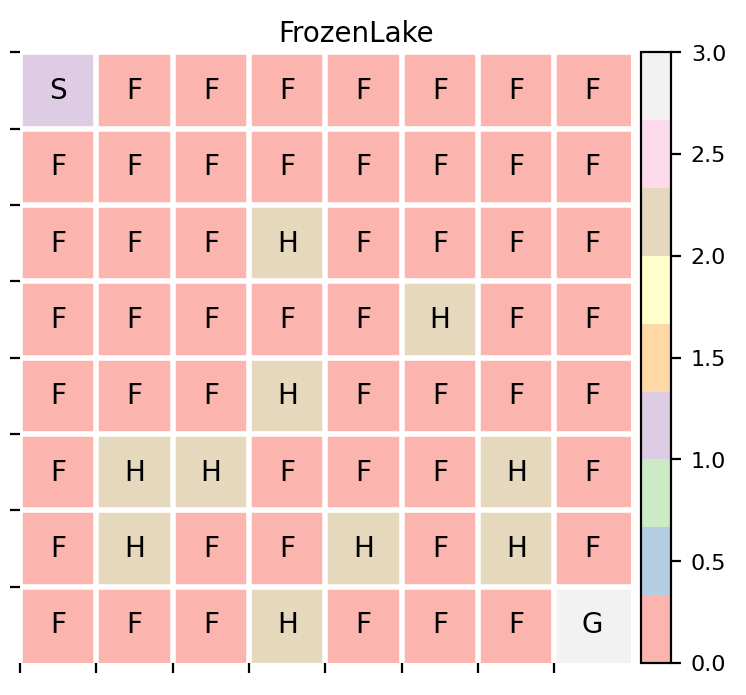

In [6]:
M = np.zeros(shape=(8,8))
strs = ['S','F','F','F','F','F','F','F',
       'F','F','F','F','F','F','F','F',
       'F','F','F','H','F','F','F','F',
       'F','F','F','F','F','H','F','F',
       'F','F','F','H','F','F','F','F',
       'F','H','H','F','F','F','H','F',
       'F','H','F','F','H','F','H','F',
       'F','F','F','H','F','F','F','G']
M[0,0] = 1 # Start
M[2,3]=M[3,5]=M[4,3]=M[5,1]=M[5,2]=M[5,6]=M[6,1]=M[6,4]=M[6,6]=M[7,3]=2 # Hole
M[7,7] = 3 # Goal
visualize_matrix(M,figsize=(4,4),fontsize=10,title_fs=10,
                 strs=strs,cmap='Pastel1',title='FrozenLake',
                 PLOT_IMG=True,RETURN_IMG=False)

### Initial Policy $\pi_0(\cdot|s)$

In [7]:
def plot_policy(Pi,figsize=(4,4),title='Policy',title_fs=10,subplots_top=1.05,
                REMOVE_TICK_LABELS=True,PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize Policy
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(np.ones((8,8,3)),extent=(0,8,8,0),cmap='Reds')
    ax.set_xticks(np.arange(0,8,1))
    ax.set_yticks(np.arange(0,8,1))
    ax.grid(color='k', linewidth=1)
    ax.set_frame_on(False)
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if Pi[s][0]> 0:
                plt.arrow(j+0.5,i+0.5,-arr_len,0,color="r",alpha=Pi[s][0],
                          width=0.01,head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][1]> 0:
                plt.arrow(j+0.5,i+0.5,0,arr_len,color="r",alpha=Pi[s][1],
                          width=0.01,head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][2]> 0:
                plt.arrow(j+0.5,i+0.5,arr_len,0,color="r",alpha=Pi[s][2],
                          width=0.01,head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][3]> 0:
                plt.arrow(j+0.5,i+0.5,0,-arr_len,color="r",alpha=Pi[s][3],
                          width=0.01,head_width=0.5,head_length=0.2,overhang=1)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    im.set_clim(vmin=0,vmax=1) # Reds
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=subplots_top)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
print ("Ready.")

Ready.


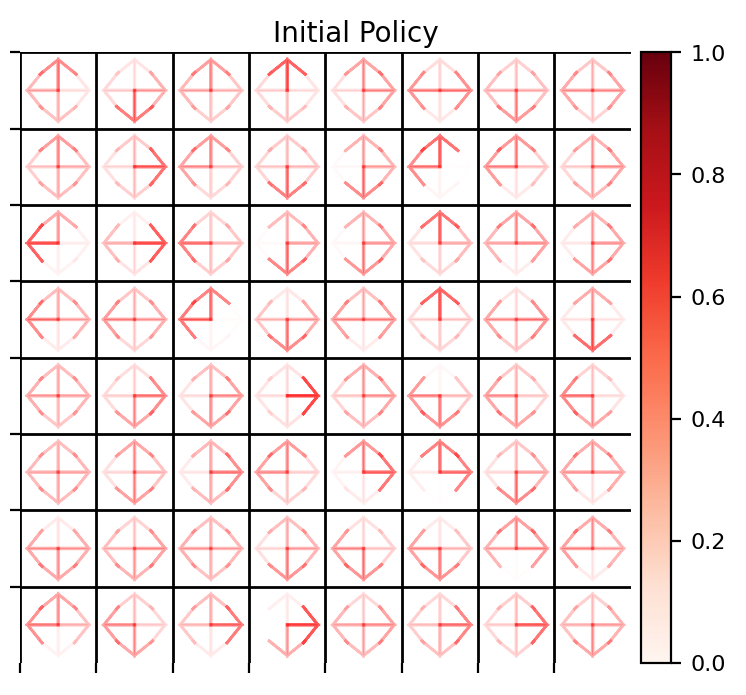

In [8]:
Pi = np.random.uniform(size=(n_state,n_action))
Pi = Pi/np.sum(Pi,axis=1,keepdims=True)
np.set_printoptions(precision=3,suppress=True)
plot_policy(Pi,title='Initial Policy',title_fs=10,subplots_top=1.05)

### Policy Evaluation
It compute the value function for a fixed policy $\pi$.

Following Bellman expectation equation for $V_{\pi}$ is used:

$
V_{\pi}(s)
=
\sum_a
\pi(a|s)
\sum_{s'}
\left[
r(s,a,s') + \gamma V_{\pi}(s')
\right]
P(s'|s,a)
$

In [9]:
def policy_evaluation(env,Pi,gamma=0.99,epsilon=1e-6):
    """
    Policy Evaluation
    """
    # Extract environment information
    obs_space = env.observation_space
    n_state = obs_space.n
    P = env.unwrapped.P
    # Random initial value function 
    V = np.random.uniform(size=(n_state,1))
    # Loop
    tick,V_dists,V_list = 0,[],[]
    while True:
        tick = tick + 1
        V_prime = np.zeros((n_state,))
        for s in P.keys(): # for all state
            for a in P[s].keys(): # for all actions
                for prob,s_prime,reward,done in P[s][a]: 
                    V_prime[s] += (reward+gamma*V[s_prime])*prob*Pi[s][a]
        V_dist = np.max(np.abs(V-V_prime))
        V_dists.append(V_dist)
        V = V_prime
        V_list.append(V)
        if V_dist < epsilon:
            break
    return V,V_dists,V_list

def plot_pi_v(Pi,V,figsize=(4,4),title='Value Function',cmap='turbo',
              title_fs=10,subplots_top=1.05,
              REMOVE_TICK_LABELS=True,PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize pi and V
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = V.shape[0],V.shape[1]
    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(V,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0))
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if Pi[s][0]> 0: plt.arrow(j+0.5,i+0.5,-arr_len,0,
                          color="r",alpha=Pi[s][0],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][1]> 0: plt.arrow(j+0.5,i+0.5,0,arr_len,
                          color="r",alpha=Pi[s][1],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][2]> 0: plt.arrow(j+0.5,i+0.5,arr_len,0,
                          color="r",alpha=Pi[s][2],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][3]> 0: plt.arrow(j+0.5,i+0.5,0,-arr_len,
                          color="r",alpha=Pi[s][3],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=subplots_top)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
print ("Ready.")

Ready.


### Run policy evaluation

In [10]:
Pi = np.random.uniform(size=(n_state,n_action))
Pi = Pi/np.sum(Pi,axis=1,keepdims=True)
start = time.time()
V,V_dists,V_list = policy_evaluation(env,Pi,gamma=0.99,epsilon=1e-6)
print("It took [%.2f]s."%(time.time()-start))
print ("Policy evaluation converged in [%d] loops."%(len(V_dists)))
print ("Done.")

It took [0.29]s.
Policy evaluation converged in [913] loops.
Done.


Plot the convergence of value iteration

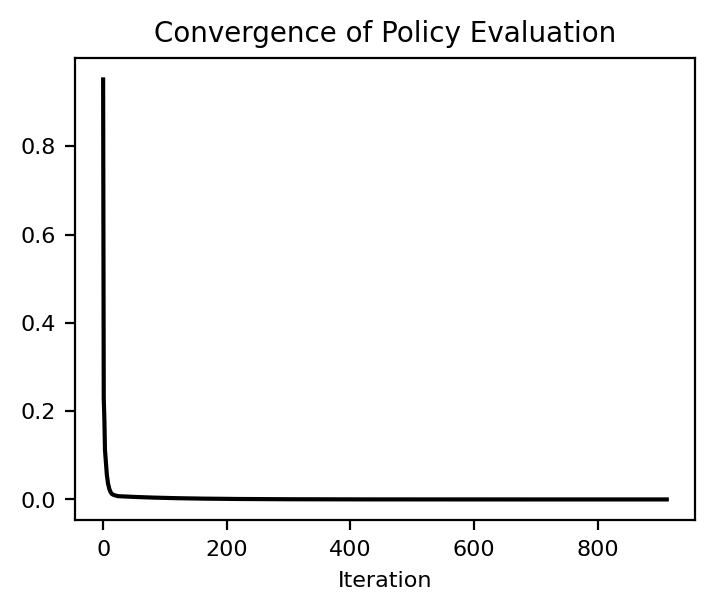

In [11]:
plt.figure(figsize=(4,3))
plt.plot(V_dists,'k-')
plt.xlabel('Iteration',fontsize=8)
plt.title("Convergence of Policy Evaluation",fontsize=10)
plt.show()

Plot how value function changes over iteration

In [12]:
n_plot = 50
frames = []
for itr in np.round(np.linspace(0,len(V_list)-1,n_plot)).astype(np.int32):
    V = V_list[itr]
    img = plot_pi_v(
        Pi,np.reshape(V,(8,8)),cmap='binary',title="Value Function@iter=%d"%(itr),
        title_fs=10,PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
media.show_video(frames, fps=5)
print ("Done.")

Done.


### This is how one step policy evaluation works

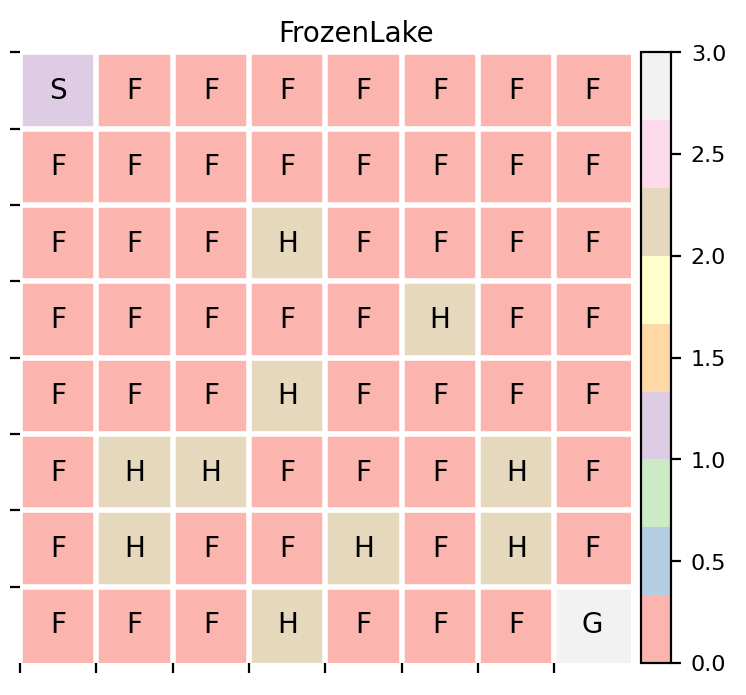

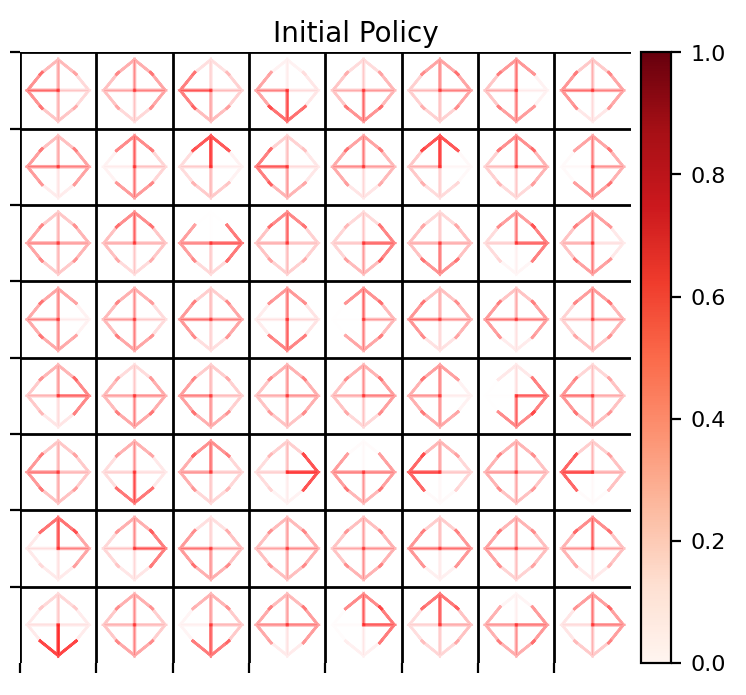

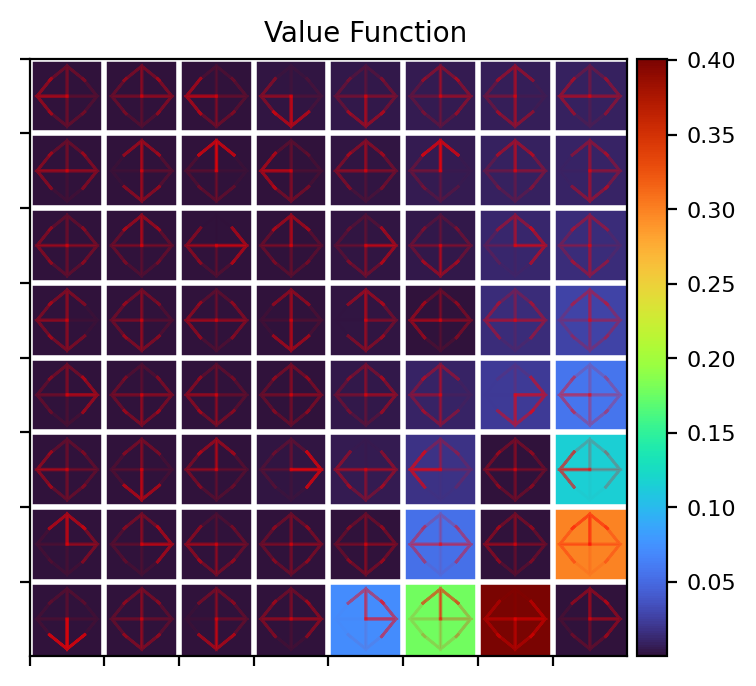

In [13]:
# Environment
visualize_matrix(M,strs=strs,cmap='Pastel1',title='FrozenLake',title_fs=10)

# Initial policy
Pi = np.random.uniform(size=(n_state,n_action))
Pi = Pi/np.sum(Pi,axis=1,keepdims=True)
np.set_printoptions(precision=3,suppress=True)
plot_policy(Pi,title='Initial Policy',title_fs=10)

# Run policy evaluation
V,V_dists,V_list = policy_evaluation(env,Pi,gamma=0.99,epsilon=1e-6)
plot_pi_v(Pi,np.reshape(V,(8,8)),
          title='Value Function',cmap='turbo',title_fs=10,REMOVE_TICK_LABELS=True)

### Policy Improvement
In this step, we update the policy distribution using the value function computed by policy evaluation. A new policy distribution is updated greedly as follows:

$Q_{\pi_k}(s,a) = \sum_{s'}
\left[
r(s,a,s') + \gamma V_{\pi_k}(s')
\right]
P(s'|s,a)
$

$\pi_{k+1} = \arg \max_a Q_{\pi_k}(s,a)$

In [14]:
def policy_improvement(env,V,gamma=0.99):
    """
    Policy Improvement
    """
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_action = act_space.n
    P = env.unwrapped.P
    Q = np.zeros((n_state,n_action))
    # Loop
    for s in P.keys(): # for all states
        for a in P[s].keys(): # for all actions
            for prob,s_prime,reward,done in P[s][a]:
                Q[s,a] += (reward + gamma*V[s_prime])*prob 
    Pi = np.zeros((n_state,n_action))
    Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
    return Pi
print ("Ready.")

Ready.


### Run policy improvement on the value achieved from policy evaluation

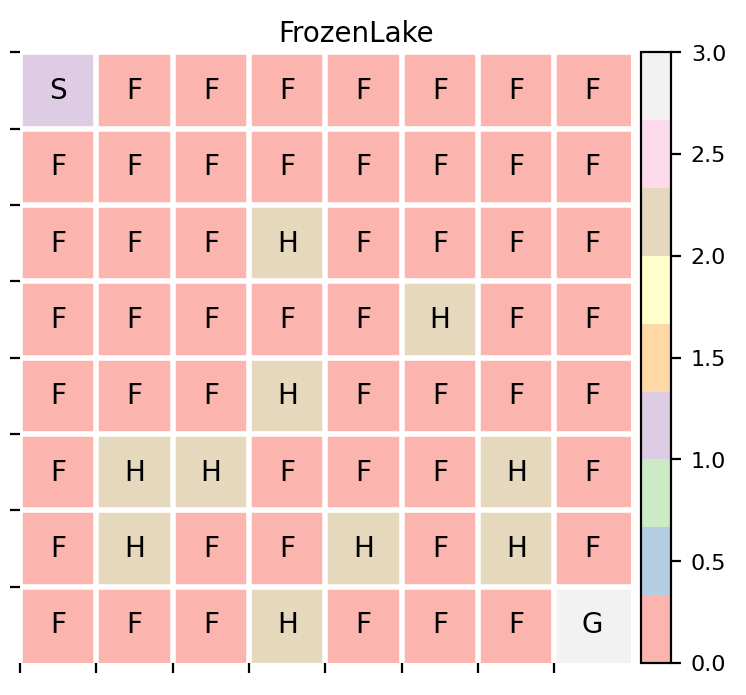

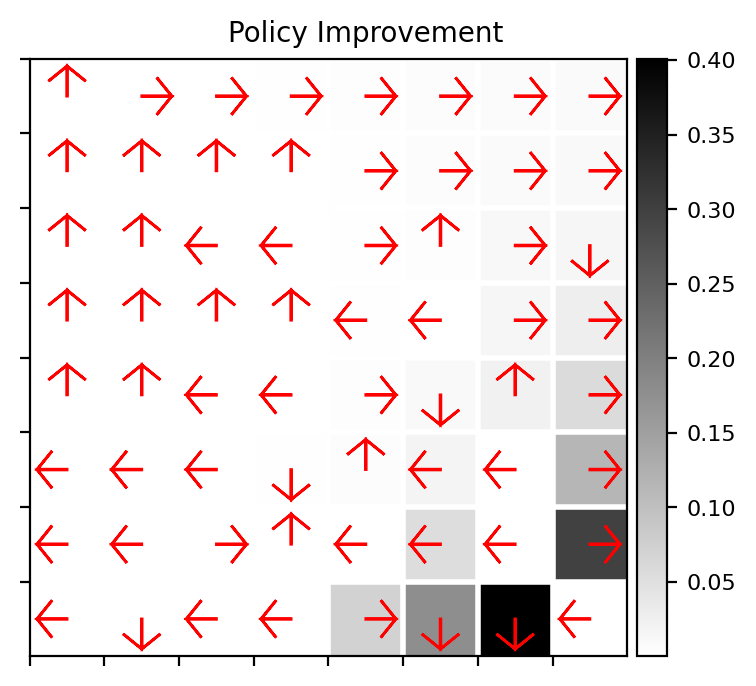

In [15]:
Pi = policy_improvement(env,V)
visualize_matrix(M,strs=strs,cmap='Pastel1',title='FrozenLake')
plot_pi_v(Pi,np.reshape(V,(8,8)),cmap='binary',title="Policy Improvement")

### Finally, Policy Iteration
Policy iteration iterates `policy evaluation` and `policy improvement`.
1. Randomly initialize the policy distribution
2. Compute the value function by `policy evaluation`
3. Update the policy by `policy improvement`
4. If the policy distribution does not change, then `stop`. Otherwise, repeat (2)~(3).

In [16]:
def policy_iteration(env,gamma=0.99,epsilon=1e-6):
    """
    Policy Iteration
    """
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_action = act_space.n
    Pi = np.random.uniform(size=(n_state,n_action))
    Pi = Pi/np.sum(Pi,axis=1,keepdims=True)
    while True:
        V,V_dists,V_list = policy_evaluation(env,Pi,gamma=gamma,epsilon=epsilon)
        Pi_prime = policy_improvement(env,V,gamma=gamma) 
        if (Pi == Pi_prime).all(): # if the policy does not change
            break
        Pi = Pi_prime
    return Pi,V
print ("Ready.")

Ready.


### Run Policy Iteration (until convergence)

In [17]:
start = time.time()
gamma = 0.99
Pi,V = policy_iteration(env,gamma=gamma)
print("It took [%.2f]s."%(time.time()-start))

It took [1.45]s.


Plot environment and the results of policy iteration

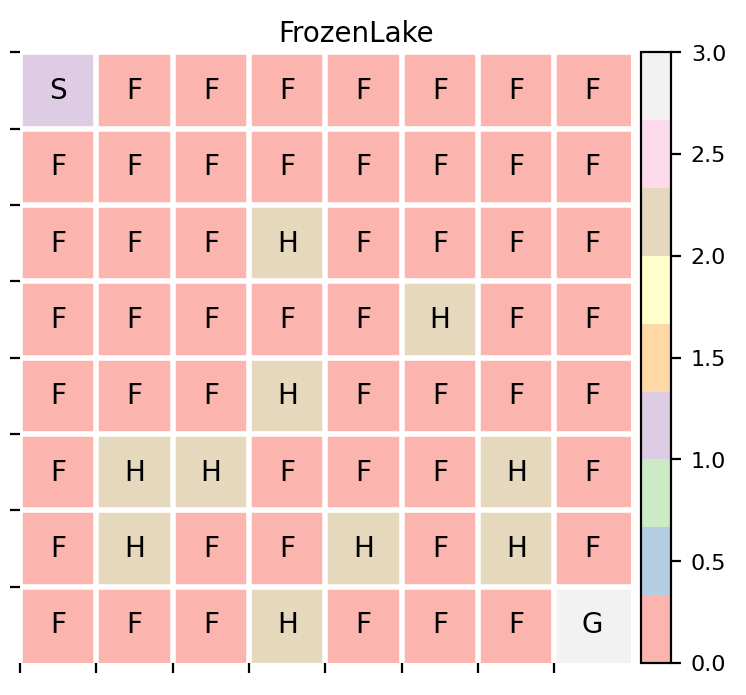

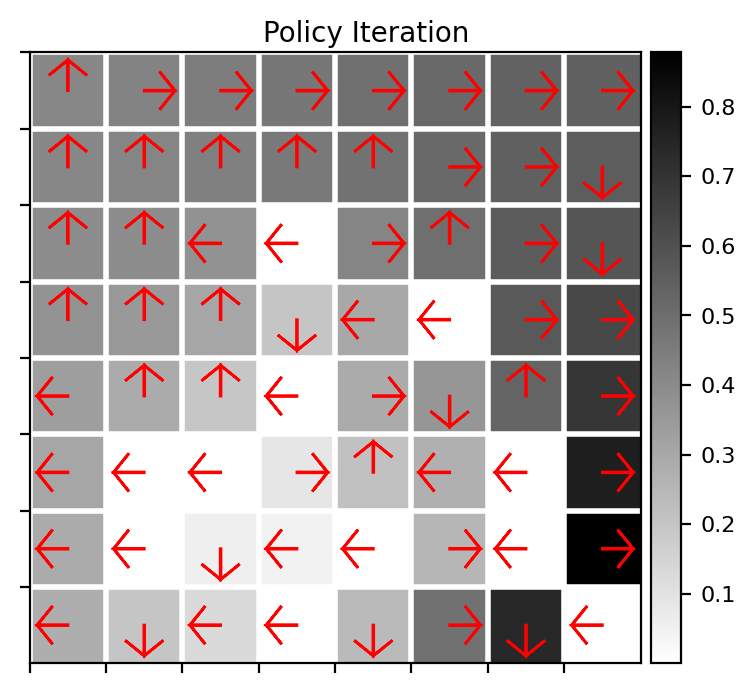

In [18]:
visualize_matrix(M,strs=strs,cmap='Pastel1',title='FrozenLake')
plot_pi_v(Pi,np.reshape(V,(8,8)),cmap='binary',title="Policy Iteration")

Animate the optimal policy

In [19]:
obs,_ = env.reset() # reset env
ret,frames = 0,[]
for tick in range(1000):
    action = np.random.choice(n_action,1,p=Pi[obs][:])[0] # select action
    next_obs,reward,done,truncated,info = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))

Return is [0.000] (tick:[31])


In [20]:
media.show_video(frames, fps=5)

Animate random policy

In [21]:
obs,_ = env.reset() # reset env
ret,frames = 0,[]
for tick in range(1000):
    action = env.action_space.sample()
    next_obs,reward,done,truncated,info = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))

Return is [0.000] (tick:[10])


In [22]:
media.show_video(frames, fps=10)

### Policy Iteraction (recap)

Policy Evaluation

$
V_{\pi}(s)
=
\sum_a
\pi(a|s)
\sum_{s'}
\left[
r(s,a,s') + \gamma V_{\pi}(s')
\right]
P(s'|s,a)
$

Policy Improvement


$Q_{\pi_k}(s,a) = \sum_{s'}
\left[
r(s,a,s') + \gamma V_{\pi_k}(s')
\right]
P(s'|s,a)
$

$\pi_{k+1} = \arg \max_a Q_{\pi_k}(s,a)$

### Policy Iteraction with Q-Value

Policy Evaluation

- $V_{k}(s) = \sum_{a'} \pi_{k}(a'|s) Q_{k}(s,a')$

- $Q_{k+1}(s,a) = \sum_{a'} \left[r(s,a,s') + \gamma V_{k}(s') \right] P(s'|s,a)$

Policy Improvement

- $\pi_{k+1}(a|s) = \mathbf{1}\left(a = \max_{a'} Q_{k+1}(s,a')\right)$

In [23]:
def q_policy_evaluation(env,P,r,Pi,gamma=0.99,epsilon=1e-6):
    """
    Policy evaluation 
     env   : environment
     P     : state transition probability [S x A x S]
     r     : reward [S]
     Pi    : policy [S x A]
    returns
     Q     : Q-value [S x A]
    """
    # Extract environment information
    n_state = env.observation_space.n
    n_action = env.action_space.n
    # Randomly initialize Q
    Q = np.random.uniform(size=(n_state,n_action))
    while True:
        V = np.sum(Pi*Q,axis=1) # [S]
        V_tile = np.tile(V[np.newaxis,np.newaxis,:],reps=(n_state,n_action,1)) # [S x A x S]
        Q_prime = np.sum((r+gamma*V_tile)*P,axis=2) # [S x A]
        Q_dist = np.max(np.max(np.abs(Q-Q_prime)))
        Q = Q_prime
        if Q_dist < epsilon:
            break
    return Q

def q_policy_improvement(env,Q):
    """
    Policy improvement
     env   : environment
     Q     : Q-value [S x A]
    """
    # Extract environment information
    n_state = env.observation_space.n
    n_action = env.action_space.n
    Pi = np.zeros((n_state,n_action))
    Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1 # Greedy policy update
    return Pi

def q_policy_iteration(env,gamma=0.99,epsilon=1e-6):
    """
    Policy iteration
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    # Random initial policy
    Pi = np.random.uniform(size=(n_state,n_action))
    Pi = Pi/np.sum(Pi,axis=1,keepdims=True)
    # Parse P and r from the environment
    P = np.zeros((n_state,n_action,n_state))
    r = np.zeros((n_state,n_action,n_state))
    for s in env.unwrapped.P.keys(): # for all states s
        for a in env.unwrapped.P[s].keys(): # for all actions a
            for prob,s_prime,reward,done in env.unwrapped.P[s][a]:
                P[s][a][s_prime] = prob # model 
                r[s][a][s_prime] = reward
    # Loop
    while True:
        Q = q_policy_evaluation(env,P,r,Pi,gamma=gamma,epsilon=epsilon) # policy evaluation
        Pi_prime = q_policy_improvement(env,Q) # policy improvement
        if (Pi == Pi_prime).all(): # if policy does not change
            break
        Pi = Pi_prime # update new policy
    return Pi,Q

print ("Ready.")

Ready.


In [24]:
def display_q_value(Q,figsize=(5,5),title="Q Function",title_fs=10,text_fs=5):
    """
    Display Q value
    """
    n_state, n_action = Q.shape
    nRow = 8
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])
    # Color
    high_color = np.array([1.0, 0.0, 0.0, 0.8])
    low_color  = np.array([1.0, 1.0, 1.0, 0.8])
    fig = plt.figure(figsize=figsize)
    plt.title(title,fontsize=title_fs)  
    for i in range(nRow):
        for j in range(nRow):
            s = i*nRow+j
            min_q = np.min(Q[s])
            max_q = np.max(Q[s])
            for a in range(n_action):
                q_value = Q[s,a]
                ratio = (q_value - min_q)/(max_q - min_q + 1e-10) 
                if ratio > 1: clr = high_color
                elif ratio < 0: clr = low_color
                else: clr = high_color*ratio + low_color*(1-ratio)
                if a == 0: # Left arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+lft_tri, color=clr, ec='k'))
                    plt.text(j-0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 1: # Down arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+dw_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i+0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 2: # Right arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+rgh_tri, color=clr, ec='k'))
                    plt.text(j+0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 3: # Up arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+up_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i-0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
    plt.xlim([-0.5,nRow-0.5])
    plt.xticks(range(nRow))
    plt.ylim([-0.5,nRow-0.5])
    plt.yticks(range(nRow))
    plt.gca().invert_yaxis()
    plt.show()
    
def plot_pi_v(Pi,V,title='Value Function',fig_size=8,cmap='turbo',title_fs=15,
              REMOVE_TICK_LABELS=True):
    """
    Visualize pi and V
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = V.shape[0],V.shape[1]
    fig,ax = plt.subplots(figsize=(fig_size,fig_size))
    divider = make_axes_locatable(ax)
    im = ax.imshow(V,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0))
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if Pi[s][0]> 0: plt.arrow(j+0.5,i+0.5,-arr_len,0,
                          color="r",alpha=Pi[s][0],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][1]> 0: plt.arrow(j+0.5,i+0.5,0,arr_len,
                          color="r",alpha=Pi[s][1],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][2]> 0: plt.arrow(j+0.5,i+0.5,arr_len,0,
                          color="r",alpha=Pi[s][2],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][3]> 0: plt.arrow(j+0.5,i+0.5,0,-arr_len,
                          color="r",alpha=Pi[s][3],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    plt.show()
    
print ("Ready.")

Ready.


### Run Q-policy iteration

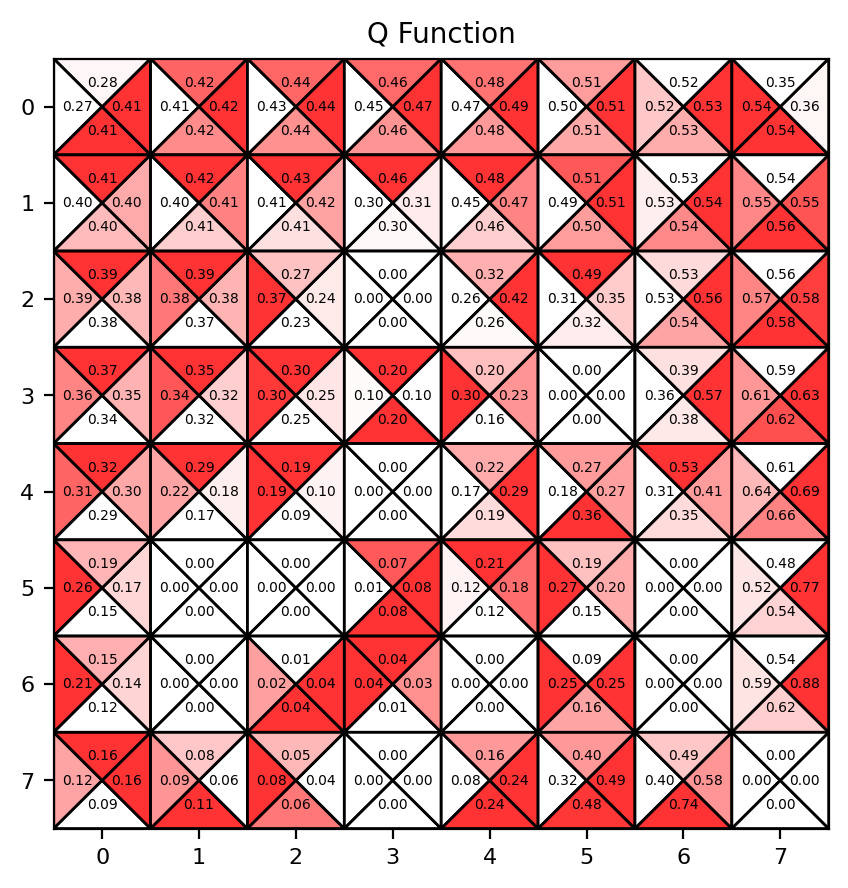

In [25]:
obs,_ = env.reset()
Pi,Q = q_policy_iteration(env)
display_q_value(Q, title="Q Function",figsize=(5,5),title_fs=10,text_fs=5)

Animate learned policy

In [26]:
obs,_ = env.reset() # reset env
ret,frames = 0,[]
for tick in range(1000):
    action = np.random.choice(n_action,1,p=Pi[obs][:])[0] # select action
    next_obs,reward,done,truncated,info = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))

Return is [1.000] (tick:[86])


In [27]:
media.show_video(frames, fps=5)